In [1]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC

In [2]:
# Read data
train_data = pd.read_csv("/Users/alex/Desktop/BT4012 Project/data/5_train_dataset.csv")
X_train = train_data.drop('is_fraud', axis=1)
y_train = train_data['is_fraud']

test_data = pd.read_csv("/Users/alex/Desktop/BT4012 Project/data/4_test_dataset.csv")
X_test = test_data.drop('is_fraud', axis=1)
y_test = test_data['is_fraud']

In [3]:
def evaluate_model(model, predX, predY):

    y_pred = model.predict(predX)

    # accuracy
    acc =  accuracy_score(predY, y_pred)
    print("Accuracy: %.2f%%" % (acc * 100))

    # precision
    precision = precision_score(predY, y_pred)
    print("Precision: %.2f%%" % (precision* 100))

    # recall
    recall = recall_score(predY, y_pred)
    print("Recall: %.2f%%" % (recall*100))

    # f1 Score
    f1 = f1_score(predY, y_pred)
    print("F1 Score: %.2f%%" % (f1*100))

    # ROC-AUC score
    roc_auc = roc_auc_score(predY, y_pred)
    print("ROC-AUC Score: %.2f%%" % (roc_auc*100))

In [4]:
rf_model = RandomForestClassifier(n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=60, bootstrap=False)
lgbm_model = LGBMClassifier(learning_rate=0.1, n_estimators=150, num_leaves=40)
xgb_model = XGBClassifier(objective='binary:logistic', colsample_bytree=0.5, learning_rate=0.9, max_depth=5, n_estimators=100, subsample=0.9)

## Stacked Model

In [5]:
stacked_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('rf', rf_model),
    ],
    cv=5 
)

stacked_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1307, number of negative: 4582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3993
[LightGBM] [Info] Number of data points in the train set: 5889, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221939 -> initscore=-1.254401
[LightGBM] [Info] Start training from score -1.254401
[LightGBM] [Info] Number of positive: 1046, number of negative: 3665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3943
[LightGBM] [Info] Number of data points in the train set: 4711, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222034 -> initscore=-1.253855
[LightGBM] [Info] Start training from score -1.253855
[LightGBM] [Info] 

StackingClassifier(cv=5,
                   estimators=[('lgbm',
                                LGBMClassifier(n_estimators=150,
                                               num_leaves=40)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None...
                                              learning_rate=0.9, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=60,
                                                       max_features='log2',
                                                       n_estimators=1200))])

In [6]:
evaluate_model(stacked_model,X_test, y_test)

Accuracy: 97.58%
Precision: 97.55%
Recall: 91.40%
F1 Score: 94.38%
ROC-AUC Score: 95.37%


## Permutation Importance 

In [7]:
r = permutation_importance(stacked_model, X_test, y_test,
                           n_repeats=15,
                           random_state=0)

In [8]:
# Get permutation importances
importances = r.importances_mean

# Create a DataFrame to display feature importances
permutation_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Permutation_Importance_Mean': importances,
})

# Rank features based on importances mean value in descending order
ranked_features = permutation_importance_df.sort_values(by='Permutation_Importance_Mean', ascending=False)

# Display the ranked features
print("Ranked Features based on Permutation Importance Mean:")
print(ranked_features)

Ranked Features based on Permutation Importance Mean:
                                     Feature  Permutation_Importance_Mean
14                            has_sent_ERC20                     0.167337
12             first_and_last_txns_time_diff                     0.021424
8                  num_unique_senders_to_acc                     0.020711
7       ERC20_num_unique_recipients_from_acc                     0.017774
10                      total_ether_received                     0.012529
5           num_received_to_total_txns_ratio                     0.007249
6                             min_value_sent                     0.006706
0            ERC20_num_unique_senders_to_acc                     0.006502
1                         total_transactions                     0.004363
17                        min_value_received                     0.002428
18                avg_time_between_sent_txns                     0.002428
16            avg_time_between_received_txns              

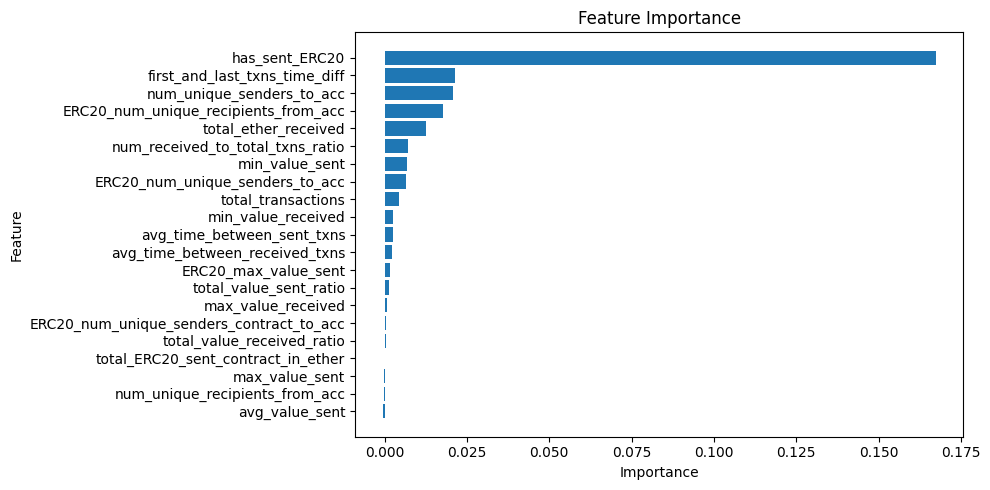

In [9]:
plt.figure(figsize=(10, 5))
plt.style.use('default')
plt.barh(ranked_features['Feature'], ranked_features['Permutation_Importance_Mean'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()